In [1]:
import dynamo as dyn
import numpy as np
import pandas as pd

print(dyn.__version__)

0.0+d595c38


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/topography.py:492: SyntaxWarning: 'scatters.parameters.no_show_legend|kwargs' is not a valid key!
  q_kwargs_dict={},


In [2]:
# use the data Peng gave me the second time 

In [3]:
Spliced_barcodes = pd.read_csv('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/Neu_Spliced_Unspliced_counts_0411/0411_Ex_Spliced_barcodes.tsv', sep = '\t', header=None)
Spliced_barcodes

Unspliced_barcodes = pd.read_csv('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/Neu_Spliced_Unspliced_counts_0411/0411_Ex_Unspliced_barcodes.tsv', sep='\t', header=None)
Unspliced_barcodes

Spliced_genes = pd.read_csv('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/Neu_Spliced_Unspliced_counts_0411/0411_Ex_Spliced_genes.tsv', sep='\t', header=None)
Spliced_genes

Unspliced_genes = pd.read_csv('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/Neu_Spliced_Unspliced_counts_0411/0411_Ex_Unspliced_genes.tsv', sep='\t', header=None)
Unspliced_genes


sum(Unspliced_barcodes.iloc[:, 0].values != Spliced_barcodes.iloc[:, 0].values)


import scipy.io

Unspliced = scipy.io.mmread('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/Neu_Spliced_Unspliced_counts_0411/0411_Ex_Unspliced.mtx')

Spliced = scipy.io.mmread('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/Neu_Spliced_Unspliced_counts_0411/0411_Ex_Spliced.mtx')


gene_union = list(set(Unspliced_genes.iloc[:, 0]).union(Spliced_genes.iloc[:, 0]))
# gene_union

gene_union = list(set(Unspliced_genes.iloc[:, 0]).union(Spliced_genes.iloc[:, 0]))
# gene_union

array1 = np.zeros((Unspliced_barcodes.shape[0], len(gene_union)))
unspliced_pd = pd.DataFrame(array1, columns=gene_union, index=Unspliced_barcodes.iloc[:, 0].tolist())
array2 = np.zeros((Unspliced_barcodes.shape[0], len(gene_union)))
spliced_pd = pd.DataFrame(array2, columns=gene_union, index=Unspliced_barcodes.iloc[:, 0].tolist())
# unspliced_pd


unspliced_pd.loc[:, Unspliced_genes.iloc[:, 0].tolist()] = Unspliced.A.T

spliced_pd.loc[:, Spliced_genes.iloc[:, 0].tolist()] = Spliced.A.T


from scipy.sparse import csr_matrix

from anndata import AnnData
neuron_splicing_4_11 = AnnData(csr_matrix(spliced_pd.values),
    var = pd.DataFrame(gene_union, index=gene_union, columns=['gene_short_name']),
    obs = pd.DataFrame(Unspliced_barcodes.iloc[:, 0].tolist(), index=Unspliced_barcodes.iloc[:, 0].tolist(), columns=['cellname']),
    layers=dict(
        unspliced=csr_matrix(unspliced_pd.values),
        spliced = csr_matrix(spliced_pd.values)))
neuron_splicing_4_11

AnnData object with n_obs × n_vars = 13476 × 44021 
    obs: 'cellname'
    var: 'gene_short_name'
    layers: 'unspliced', 'spliced'

In [4]:
# save splicing data 

In [5]:
neuron_splicing_4_11.write_h5ad('/home/xqiu/proj/Aristotle/data/u_penn_data/data/revision_data/neuron_splicing_4_11.h5ad')

In [6]:
# read in the labeling data 

In [7]:
Neu = dyn.read_h5ad('/home/xqiu/proj/Aristotle/data/u_penn_data/data/revision_data/Neu_one_shot.h5ad') # Neu

In [8]:
Neu

AnnData object with n_obs × n_vars = 18133 × 37661 
    obs: 'nGene', 'nUMI', 'time', 'cluster'
    var: 'gene_short_name'
    layers: 'new', 'total'

In [9]:
# update neuron_splicing_4_11's obs 

In [10]:
# neuron_splicing.obs = Neu.obs.loc[neuron_splicing.obs.index, :]
neuron_splicing_4_11.obs = Neu.obs.loc[neuron_splicing_4_11.obs.index, :]


In [11]:
neuron_splicing_4_11

AnnData object with n_obs × n_vars = 13476 × 44021 
    obs: 'nGene', 'nUMI', 'time', 'cluster'
    var: 'gene_short_name'
    layers: 'unspliced', 'spliced'

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 13476 × 97 
    obs: 'nGene', 'nUMI', 'time', 'cluster', 'label_time'
    var: 'gene_short_name'
    layers: 'unspliced', 'spliced'


Trying to set attribute `.obs` of view, copying.
estimating gamma: 100%|██████████| 97/97 [00:05<00:00, 21.47it/s]
/home/xqiu/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


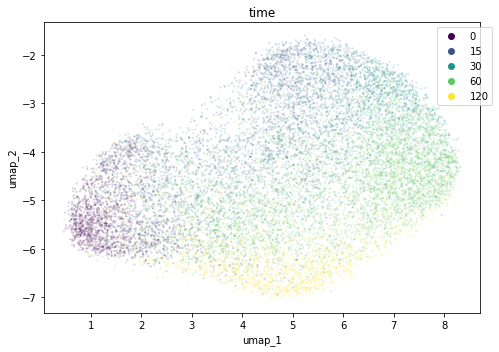

In [12]:
adata = neuron_splicing_4_11.copy()

n_top_genes=1001 # this is larger than 97 neuronal activity genes, all genes will thus be selected for pca 
time = ['0', '15', '30', '60', '120'] # , '60', '120'
cell_type=['Ex']

peng_gene_list = pd.read_csv('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/0408_grp_info.txt', sep='\t')

model = 'stochastic'
tkey = 'time'
if cell_type is not None: adata = adata[adata.obs.cluster.isin(cell_type), :]

adata.obs['label_time'] = 2
adata = adata[adata.obs.time.isin(time), :]

adata.obs['time'] = adata.obs.time.astype('category') # set time as category, so that we can plot 0, 15, 30, 60 and 120 as a sequence
adata = adata[:, peng_gene_list.index]
print(adata)
# note the fc_kwargs, fg_kwargs are useful because we are only look at 97 cells in total 
adata = dyn.pp.recipe_monocle(adata, n_top_genes=n_top_genes, 
                              fc_kwargs={"min_expr_genes_s": 5,
                                         "min_expr_genes_u": 2,}, 
                              fg_kwargs={"shared_count": 5},
                      )

dyn.tl.dynamics(adata, model=model)

dyn.tl.reduceDimension(adata, reduction_method='umap')
dyn.pl.umap(adata, color='time', save_show_or_return='show', color_key_cmap = 'viridis')

In [13]:
hao_gene_list = ["Egr1", "Fos", "Fosb", "Ier2", "Jun", "Nr4a3", "Homer1", "Fosl2", "Nefl", "Maff"]
dyn.pl.phase_portraits(adata, genes=hao_gene_list, color='time',  discrete_continous_div_color_key=[None, None, None], discrete_continous_div_color_key_cmap=['viridis', None, None], ncols=6, save_kwargs={'prefix': 'splicing_hao_gene_list_pp'}, save_show_or_return='save', pointsize=5)

# dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[90:], color='time', discrete_continous_div_color_key=[None, None, None], discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save')
dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[0:25], color='time', discrete_continous_div_color_key=[None, None, None], discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'splicing_pp_0_25'})
dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[25:50], color='time', discrete_continous_div_color_key=[None, None, None], discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'splicing_pp_25_50'})
dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[50:75], color='time', discrete_continous_div_color_key=[None, None, None], discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'splicing_pp_50_75'})
dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[75:], color='time', discrete_continous_div_color_key=[None, None, None], discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'splicing_pp_75_above'})


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_hao_gene_list_pp_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_pp_0_25_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_pp_25_50_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_pp_50_75_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_pp_75_above_dyn_savefig.pdf...
Done


In [14]:
dyn.tl.cell_velocities(adata, calc_rnd_vel=True) # 

dyn.pl.cell_wise_velocity(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, quiver_size=4,
                          quiver_length=5, save_show_or_return='save', save_kwargs={'prefix': 'splicing_cell_wise_velocity'})  # ['GRIA3', 'LINC00982', 'AFF2']

dyn.pl.grid_velocity(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, save_show_or_return='save', save_kwargs={'prefix': 'splicing_grid_velocity'})  # ['GRIA3', 'LINC00982', 'AFF2']

#adata.obsm['X_umap_rnd'] = adata.obsm['X_umap']
dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap_rnd', ncols=5, show_legend='on data', save_show_or_return='save', save_kwargs={'prefix': 'splicing_streamline_rnd'})  # ['GRIA3', 'LINC00982', 'AFF2']
dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap_rnd', ncols=5, save_show_or_return='save', save_kwargs={'prefix': 'splicing_streamline_rnd_legend'})  # ['GRIA3', 'LINC00982', 'AFF2']

dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, show_legend='on data', save_show_or_return='save', save_kwargs={'prefix': 'splicing_stream_velocity', 'ext': 'svg'})  # ['GRIA3', 'LINC00982', 'AFF2']
dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, save_show_or_return='save', save_kwargs={'prefix': 'splicing_stream_velocity_legend', 'ext': 'svg'})  # ['GRIA3', 'LINC00982', 'AFF2']


calculating density corrected drift: 100%|██████████| 13476/13476 [00:04<00:00, 2721.48it/s]
/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_cell_wise_velocity_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_grid_velocity_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_streamline_rnd_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_streamline_rnd_legend_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_stream_velocity_dyn_savefig.svg...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/splicing_stream_velocity_legend_dyn_savefig.svg...
Done


<Figure size 432x288 with 0 Axes>

In [15]:
adata.var.use_for_velocity.sum()

2

In [16]:
# r2 for the splicing data 

In [17]:
adata[:, hao_gene_list].var.loc[:, 'gamma_r2']

Egr1     -0.010560
Fos      -0.031659
Fosb     -0.760366
Ier2      0.000000
Jun       0.000000
Nr4a3    -0.704278
Homer1    0.383652
Fosl2    -0.205651
Nefl      0.000000
Maff     -0.183783
Name: gamma_r2, dtype: float64

In [18]:
# let use the approximate (time corrected) NTR velocity 

In [19]:
adata = Neu.copy()

n_top_genes=1001
time = ['0', '15', '30', '60', '120'] # this is the stimulation time 
cell_type=['Ex']

peng_gene_list = pd.read_csv('/home/xqiu/proj/Aristotle/data/u_penn_data/scNT_revision/0408_grp_info.txt', sep='\t')

model = 'stochastic'
if cell_type is not None: adata = adata[adata.obs.cluster.isin(cell_type), :]

adata.obs['label_time'] = 2 # this is the labeling time 
tkey = 'label_time'
adata = adata[adata.obs.time.isin(time), :]

adata = adata[:, peng_gene_list.index]
adata = dyn.pp.recipe_monocle(adata, n_top_genes=n_top_genes, fc_kwargs={"min_expr_genes_s": 5,
    "min_expr_genes_u": 2,}, fg_kwargs={"shared_count": 5},
#                       keep_filtered_cells=False,
#                       keep_filtered_genes=False,
                      # total_layers='spliced',
                      )

dyn.tl.dynamics(adata, model=model, tkey=tkey)

dyn.tl.reduceDimension(adata, reduction_method='umap')

dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
adata.obs['time'] = adata.obs.time.astype('category')

dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[0:25], color='time', discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'labeling_pp_0_25'})
dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[25:50], color='time', discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'labeling_pp_25_50'})
dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[50:75], color='time', discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'labeling_pp_50_75'})
dyn.pl.phase_portraits(adata, genes=peng_gene_list.index[75:], color='time', discrete_continous_div_color_key_cmap=['viridis', None, None], save_show_or_return='save', pointsize=3, save_kwargs={'prefix': 'labeling_pp_75_above'})

hao_gene_list = ["Egr1", "Fos", "Fosb", "Ier2", "Jun", "Nr4a3", "Homer1", "Fosl2", "Nefl", "Maff"]
dyn.pl.phase_portraits(adata, genes=hao_gene_list, color='time',  discrete_continous_div_color_key=[None, None, None], discrete_continous_div_color_key_cmap=['viridis', None, None], ncols=6, save_kwargs={'prefix': 'hao_gene_list_pp'}, save_show_or_return='save', pointsize=5)

dyn.pl.cell_wise_velocity(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, quiver_size=4,
                          quiver_length=5, save_show_or_return='save', save_kwargs={'prefix': 'labeling_cell_wise_velocity'})  # ['GRIA3', 'LINC00982', 'AFF2']

dyn.pl.grid_velocity(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, save_show_or_return='save', save_kwargs={'prefix': 'labeling_grid_velocity'})  # ['GRIA3', 'LINC00982', 'AFF2']
dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap_rnd', ncols=5, show_legend='on data', save_show_or_return='save', save_kwargs={'prefix': 'labeling_streamline_rnd', 'ext': 'svg'})  # ['GRIA3', 'LINC00982', 'AFF2']
dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap_rnd', ncols=5, save_show_or_return='save', save_kwargs={'prefix': 'labeling_streamline_rnd_legend', 'ext': 'svg'})  # ['GRIA3', 'LINC00982', 'AFF2']

dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, show_legend='on data', save_show_or_return='save', save_kwargs={'prefix': 'labeling_stream_velocity'})  # ['GRIA3', 'LINC00982', 'AFF2']
dyn.pl.streamline_plot(adata, color='time', color_key_cmap = 'viridis', basis='umap', ncols=5, save_show_or_return='save', save_kwargs={'prefix': 'labeling_stream_velocity_legend', 'ext': 'svg'})  # ['GRIA3', 'LINC00982', 'AFF2']


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
estimating gamma: 100%|██████████| 97/97 [00:07<00:00, 15.46it/s]
/home/xqiu/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
calculating density corrected drift: 100%|██████████| 13511/13511 [00:05<00:00, 2263.58it/s]
/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_pp_0_25_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_pp_25_50_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_pp_50_75_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_pp_75_above_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+d595c38-py3.6.egg/dynamo/plot/dynamics.py:174: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  div_scatter_kwargs.update({"norm": DivergingNorm(0)})


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/hao_gene_list_pp_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_cell_wise_velocity_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_grid_velocity_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_streamline_rnd_dyn_savefig.svg...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_streamline_rnd_legend_dyn_savefig.svg...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_stream_velocity_dyn_savefig.pdf...
Done


/home/xqiu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


Saving figure to /home/xqiu/proj/Aristotle/data/u_penn_data/labeling_stream_velocity_legend_dyn_savefig.svg...
Done


<Figure size 650x500 with 0 Axes>

In [20]:
adata = adata[adata.obs.time.isin(time), :]
adata.obs.time

Series([], Name: time, dtype: category
Categories (0, int64): [])

In [21]:
adata[:, hao_gene_list].var.loc[:, 'gamma_r2']

Egr1      0.768058
Fos       0.841485
Fosb      0.664249
Ier2      0.457303
Jun       0.429006
Nr4a3     0.780770
Homer1    0.396524
Fosl2     0.429296
Nefl      0.560899
Maff     -0.485690
Name: gamma_r2, dtype: float64

In [22]:
adata

View of AnnData object with n_obs × n_vars = 0 × 97 
    obs: 'nGene', 'nUMI', 'time', 'cluster', 'label_time', 'use_for_dynamo', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size'
    var: 'gene_short_name', 'pass_basic_filter', 'use_for_dynamo', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_velocity'
    uns: 'pp_log', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'moments_con', 'dynamics', 'neighbors', 'umap_fit', 'velocity_pca_fit', 'velocity_PCs', 'kmc', 'transition_matrix', 'grid_velocity_umap', 'transition_matrix_rnd', 'grid_velocity_umap_rnd'
    obsm: 'X_pca', 'X_umap', 'X_velocity_pca', 'velocity_pca_raw', 'velocity_umap', 'X_umap_rnd', 'velocity_umap_rnd'
    varm: 'alpha'
    layers: 'new', 'total', 'X_new', 'X_total', 'M_t

In [23]:
adata.obs['umap_0'] = adata.obsm['X_umap'][:, 0]
adata.obs['umap_1'] = adata.obsm['X_umap'][:, 1]


Trying to set attribute `.obs` of view, copying.
Transforming to str index.


In [24]:
adata.obs.to_csv('adata_NTR_obs.csv')

In [25]:
!pwd

/home/xqiu/proj/Aristotle/data/u_penn_data
